# Stock Market Prediction

### TASK
#### Stock Market Prediction using Numerical and Textual Analysis
The task is to create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices and sentimental analysis of news headlines.

Download historical stock prices from https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231

Download textual (news) data from https://bit.ly/36fFPI6

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from math import sqrt
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D,Bidirectional
from keras.optimizers import SGD,Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asaifali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/asaifali/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df_prices = pd.read_csv("/Users/asaifali/Desktop/Internships/The Spark Foundation/BSESN.csv")
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0
...,...,...,...,...,...,...,...
247,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0
248,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0
249,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0
250,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,46666.460938,13100.0


In [3]:
cols = ['Date','Category','News']
df_news = pd.read_csv('/Users/asaifali/Desktop/Internships/The Spark Foundation/india-news-headlines.csv', names = cols)
df_news = df_news.dropna(axis = 0, how ='any') 
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


## Cleaning and Pre-processing the data:

In [4]:
# Dropping 0 values, and the Category column as we don't require this for our analysis.
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)

In [5]:
# Converting 'Date' columns from both our dataframes to type datetime
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0
...,...,...,...,...,...,...,...
247,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0
248,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0
249,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0
250,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,46666.460938,13100.0


In [6]:
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic; demand for styl...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
7715,2022-03-30,I will not give in to trends: Dossmode The tim...


In [7]:
# Cleaning headlines
c = []

for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)    

In [8]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
1,2001-01-03,powerless north india grope dark think laxman ...
2,2001-01-04,string pull stephen hawk india vajpaye give bi...
3,2001-01-05,light combat craft take india club class hawk ...
4,2001-01-06,light combat craft take india club class hawk ...
...,...,...
7712,2022-03-27,play dead man bodi god meant sit refriger guru...
7713,2022-03-28,fashion becom democrat demand stylist soar las...
7714,2022-03-29,bobbi deol like dad hope work age yasha surya ...
7715,2022-03-30,give trend dossmod time gave boyfriend incred ...


### Calculating Subjectivity and Polarity scores using TextBlob module:

In [9]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [10]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394
...,...,...,...,...
7712,2022-03-27,play dead man bodi god meant sit refriger guru...,0.356716,0.087855
7713,2022-03-28,fashion becom democrat demand stylist soar las...,0.382331,0.079270
7714,2022-03-29,bobbi deol like dad hope work age yasha surya ...,0.372864,0.083037
7715,2022-03-30,give trend dossmod time gave boyfriend incred ...,0.330696,0.052339


## Data Visualisation

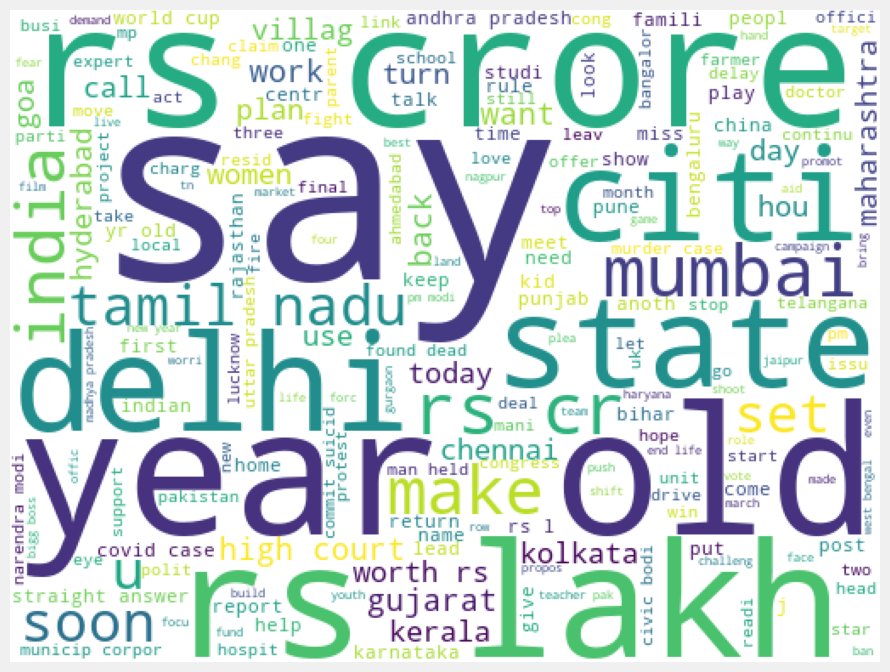

In [11]:
from wordcloud import WordCloud
from scipy import signal
DF = df_news.dropna(False)
plt.subplots(figsize=(10,10))
wordcloud = WordCloud(background_color = 'white',
                     width = 512,
                     height = 384).generate(' '.join(df_news['News']))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

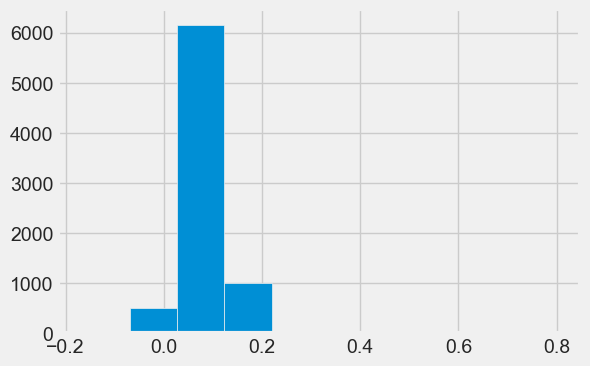

In [12]:
#histogram Polarity
plt.figure(figsize=(6,4))
df_news['Polarity'].hist()
plt.show()

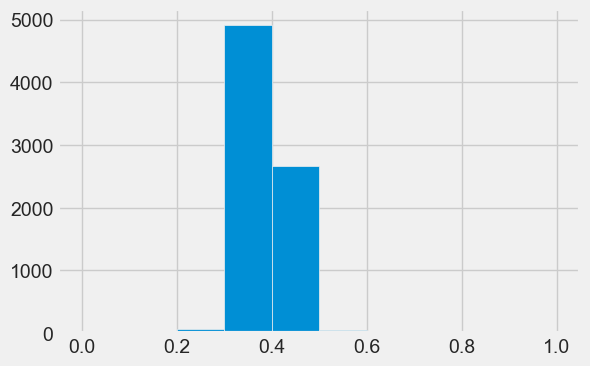

In [13]:
#Histogram Subjectivity
plt.figure(figsize=(6,4))
df_news['Subjectivity'].hist()
plt.show()

## Carrying out Sentimental Analysis on the News Headlines:

In [14]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394,-0.7579,0.207,0.649,0.144
...,...,...,...,...,...,...,...,...
7712,2022-03-27,play dead man bodi god meant sit refriger guru...,0.356716,0.087855,-0.9999,0.149,0.782,0.069
7713,2022-03-28,fashion becom democrat demand stylist soar las...,0.382331,0.079270,-0.9998,0.144,0.778,0.078
7714,2022-03-29,bobbi deol like dad hope work age yasha surya ...,0.372864,0.083037,-0.9997,0.129,0.799,0.072
7715,2022-03-30,give trend dossmod time gave boyfriend incred ...,0.330696,0.052339,-0.9998,0.139,0.794,0.067


## Merging Sentimental Analysis data with historical prices data for predicting stock prices using Multivariate Time Series Forecasting:



In [15]:
# Merging our findings (the updated News dataframe) with the Prices dataframe
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
print(df_prices)
df_merge.drop('Date', axis = 1, inplace=True)
df_merge.drop('News', axis=1, inplace=True)
print(df_merge.columns)
print(len(df_merge))
print(len(df_prices))
print(len(df_news))

          Date          Open          High           Low         Close  \
0   2019-12-17  41052.359375  41401.648438  41005.179688  41352.171875   
1   2019-12-18  41442.750000  41614.769531  41358.468750  41558.570313   
2   2019-12-19  41571.820313  41719.289063  41456.398438  41673.921875   
3   2019-12-20  41746.199219  41809.960938  41636.109375  41681.539063   
4   2019-12-23  41548.261719  41701.621094  41474.609375  41642.660156   
..         ...           ...           ...           ...           ...   
247 2020-12-11  46060.320313  46309.628906  45706.218750  46099.011719   
248 2020-12-14  46284.699219  46373.339844  45951.531250  46253.460938   
249 2020-12-15  46287.390625  46350.300781  45841.671875  46263.171875   
250 2020-12-16  46573.308594  46704.968750  46402.199219  46666.460938   
251 2020-12-17  46774.320313  46992.570313  46627.601563  46890.339844   

        Adj Close   Volume  
0    41352.171875  19000.0  
1    41558.570313  24300.0  
2    41673.921875  33300

In [16]:
# getting our data series ready for Multivariate Time Series Forecasting
from pandas import DataFrame as df
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df1 = df(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df1.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df1.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [17]:
# scale our data for optimal performance
values = df_merge.values
print(df_merge)
print(values)
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[12,13,14,16,17,18,19,20,21,22,23]], axis=1, inplace=True)
print(reframed.columns)

             Open          High           Low         Close     Adj Close  \
0    41052.359375  41401.648438  41005.179688  41352.171875  41352.171875   
1    41442.750000  41614.769531  41358.468750  41558.570313  41558.570313   
2    41571.820313  41719.289063  41456.398438  41673.921875  41673.921875   
3    41746.199219  41809.960938  41636.109375  41681.539063  41681.539063   
4    41548.261719  41701.621094  41474.609375  41642.660156  41642.660156   
..            ...           ...           ...           ...           ...   
247  46060.320313  46309.628906  45706.218750  46099.011719  46099.011719   
248  46284.699219  46373.339844  45951.531250  46253.460938  46253.460938   
249  46287.390625  46350.300781  45841.671875  46263.171875  46263.171875   
250  46573.308594  46704.968750  46402.199219  46666.460938  46666.460938   
251  46774.320313  46992.570313  46627.601563  46890.339844  46890.339844   

      Volume  Subjectivity  Polarity  Compound  Negative  Neutral  Positive

### Building a Bi-GRU (Bidirectional-Gated Recurrent Units) Model to predict Stock Prices:

Gated Recurrent Units

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the output, .neither they have the output gate.

In [38]:
# split into train and test sets
values = reframed.values
print((values).shape)
n_train_hours = 90
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(247, 13)
(90, 1, 12) (90,) (157, 1, 12) (157,)


In [19]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(GRU(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]))))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        loss='mae',
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=3,
    directory='my_dir',
    project_name='Bi-GRU_tuning')

tuner.search(train_X, train_y, epochs=96, validation_split=0.1, batch_size=1, verbose=2, shuffle=False)


Using TensorFlow backend
Reloading Tuner from my_dir/Bi-GRU_tuning/tuner0.json


In [20]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best Hyperparameters: {best_hps.values}")

# Extract and print the specific hyperparameters
best_units = best_hps.get('units')
best_learning_rate = best_hps.get('learning_rate')

print(f"Best Units: {best_units}")
print(f"Best Learning Rate: {best_learning_rate}")


Best Hyperparameters: {'units': 256, 'learning_rate': 0.01}
Best Units: 256
Best Learning Rate: 0.01


Epoch 1/96
2/2 - 1s - loss: 0.3907 - val_loss: 0.0730 - 1s/epoch - 727ms/step
Epoch 2/96
2/2 - 0s - loss: 0.3178 - val_loss: 0.1313 - 26ms/epoch - 13ms/step
Epoch 3/96
2/2 - 0s - loss: 0.2793 - val_loss: 0.1701 - 26ms/epoch - 13ms/step
Epoch 4/96
2/2 - 0s - loss: 0.2164 - val_loss: 0.1927 - 23ms/epoch - 12ms/step
Epoch 5/96
2/2 - 0s - loss: 0.1834 - val_loss: 0.2069 - 24ms/epoch - 12ms/step
Epoch 6/96
2/2 - 0s - loss: 0.1580 - val_loss: 0.2057 - 28ms/epoch - 14ms/step
Epoch 7/96
2/2 - 0s - loss: 0.1429 - val_loss: 0.1884 - 24ms/epoch - 12ms/step
Epoch 8/96
2/2 - 0s - loss: 0.1298 - val_loss: 0.1571 - 24ms/epoch - 12ms/step
Epoch 9/96
2/2 - 0s - loss: 0.1211 - val_loss: 0.1182 - 23ms/epoch - 12ms/step
Epoch 10/96
2/2 - 0s - loss: 0.1262 - val_loss: 0.0789 - 24ms/epoch - 12ms/step
Epoch 11/96
2/2 - 0s - loss: 0.1188 - val_loss: 0.0493 - 26ms/epoch - 13ms/step
Epoch 12/96
2/2 - 0s - loss: 0.1057 - val_loss: 0.0326 - 22ms/epoch - 11ms/step
Epoch 13/96
2/2 - 0s - loss: 0.1014 - val_loss: 0.

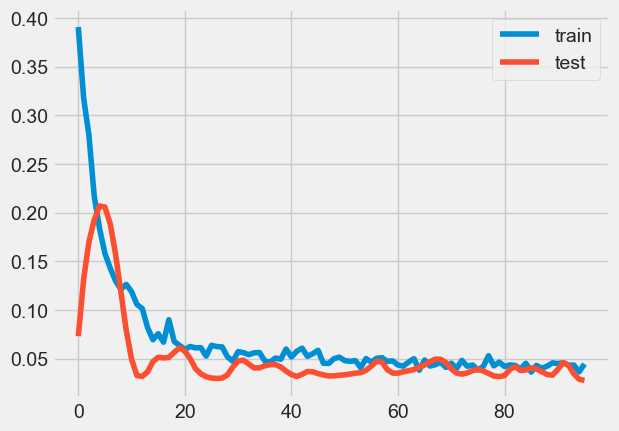

In [37]:
best_model = tuner.get_best_models(num_models=1)[0]

# Fit the model with the best hyperparameters
history = best_model.fit(train_X, train_y,epochs=96, batch_size=72, validation_split=0.1, verbose=2, shuffle=False)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


### **Testing** the Bi GRU Model with the test data and calculating **RMSE(Root Mean Square Error)**:

In [39]:
# Make a prediction
print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[2]))
print(test_X.shape)
yhat = best_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


(157, 1, 12)
(157, 1, 12)
5/5 [==============================] - 0s 1ms/step
Test RMSE: 997.265


A Root Mean Square Error (RMSE) less than 1000 is context-dependent. To assess whether this is a good RMSE for our specific problem, we need to consider the scale of the target variable and the requirements of our application. 

In our context, if the Sensex prices are in the order of 48,000 units and the RMSE less than 1000 is good, it means that, on average, your model's predictions can be off by approximately 1000 units. In terms of percentage error, this would be:

(997 / 48,000) * 100 ≈ 1.97%

An RMSE of 1.97% relative to the scale of our data may be considered good, especially it meets the accuracy requirements of our application.